# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU.

**Make sure you use the best practices you learned in class**.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 104296059.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
       cat       frog      plane       frog


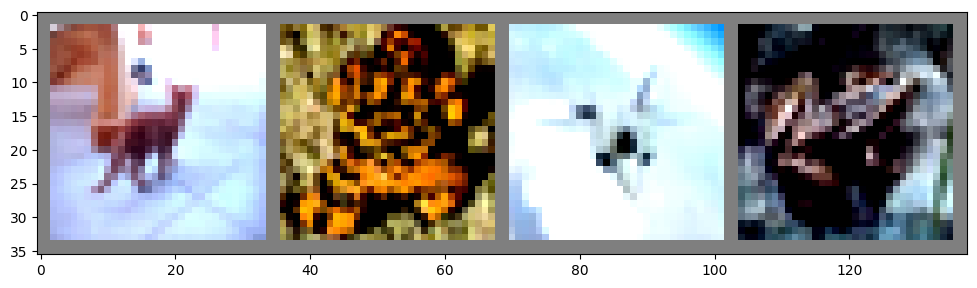

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value.

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class.
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs.
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        self.train_losses = []
        self.test_losses = []

        self.train_accuracies = []
        self.test_accuracies = []

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################

        x = self.pool1(self.relu(self.bn2(self.conv2(self.bn1(self.conv1(x)))))) # block 1
        x = self.pool1(self.relu(self.bn4(self.conv4(self.bn3(self.conv3(x)))))) # block 1
        x = self.pool1(self.relu(self.bn6(self.conv6(self.bn5(self.conv5(x)))))) # block 1
        x = self.pool4(self.relu(self.bn7(self.conv7(x)))) # block 4

        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net()
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   #
#############################################################################

optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [5]:
if torch.cuda.is_available():
    # Print the GPU device name
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available, using CPU.")

GPU: Tesla T4


In [6]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        #
#############################################################################
def train(net, optimizer, step_size, epochs):
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.3)

  if torch.cuda.is_available():
    net = net.to(device)
  for epoch in range(epochs):
    net.train()
    # Train
    train_corrects = 0
    for X_batch, y_batch in trainloader:
        if torch.cuda.is_available():
          X_batch = X_batch.to(device) # input to device as our model is running in mentioned device.
          y_batch = y_batch.to(device)
        optimizer.zero_grad()

        y_scores = net(X_batch)
        y_pred = torch.argmax(y_scores, axis=1)
        train_corrects += torch.sum(y_pred == y_batch).item()

        train_loss = criterion(y_scores, y_batch)
        train_loss.backward()

        optimizer.step()
    train_accuracy = train_corrects / len(trainset)
    net.train_accuracies.append(train_accuracy)
    net.train_losses.append(train_loss.item())
    scheduler.step()

    # Validation
    net.eval()

    correct = 0
    total = 0

    with torch.no_grad():
      test_corrects = 0
      for X_batch, y_batch in testloader:
        if torch.cuda.is_available():
          X_batch = X_batch.to(device)
          y_batch = y_batch.to(device)

        y_scores = net(X_batch)
        y_pred = torch.argmax(y_scores, axis=1)
        test_corrects += torch.sum(y_pred == y_batch).item()
        test_loss = criterion(y_scores, y_batch)

      test_accuracy = test_corrects / len(testset)
      net.test_accuracies.append(test_accuracy)

      net.test_losses.append(test_loss.item())

    print(f'Epoch {epoch+1}/{epochs}, Test Loss: {net.test_losses[-1]} | Train Loss: {net.train_losses[-1]} | Test Accuracy: {net.test_accuracies[-1]} | Train Accuracy: {net.train_accuracies[-1]}')

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [7]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.0012)
train(net, optimizer, 6, 9)

Epoch 1/9, Test Loss: 0.9987409710884094 | Train Loss: 1.2190502882003784 | Test Accuracy: 0.6121 | Train Accuracy: 0.50626
Epoch 2/9, Test Loss: 0.9040279984474182 | Train Loss: 1.1801098585128784 | Test Accuracy: 0.7087 | Train Accuracy: 0.68332
Epoch 3/9, Test Loss: 0.5159478783607483 | Train Loss: 1.1073756217956543 | Test Accuracy: 0.7572 | Train Accuracy: 0.7532
Epoch 4/9, Test Loss: 0.6381052732467651 | Train Loss: 0.6309337019920349 | Test Accuracy: 0.7807 | Train Accuracy: 0.79308
Epoch 5/9, Test Loss: 0.4553437829017639 | Train Loss: 0.3680160939693451 | Test Accuracy: 0.795 | Train Accuracy: 0.825
Epoch 6/9, Test Loss: 0.4933793544769287 | Train Loss: 0.2900954484939575 | Test Accuracy: 0.807 | Train Accuracy: 0.85278
Epoch 7/9, Test Loss: 0.2528173625469208 | Train Loss: 0.721882700920105 | Test Accuracy: 0.8387 | Train Accuracy: 0.91834
Epoch 8/9, Test Loss: 0.2664797902107239 | Train Loss: 0.14519120752811432 | Test Accuracy: 0.8434 | Train Accuracy: 0.9401
Epoch 9/9, Tes

## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)**

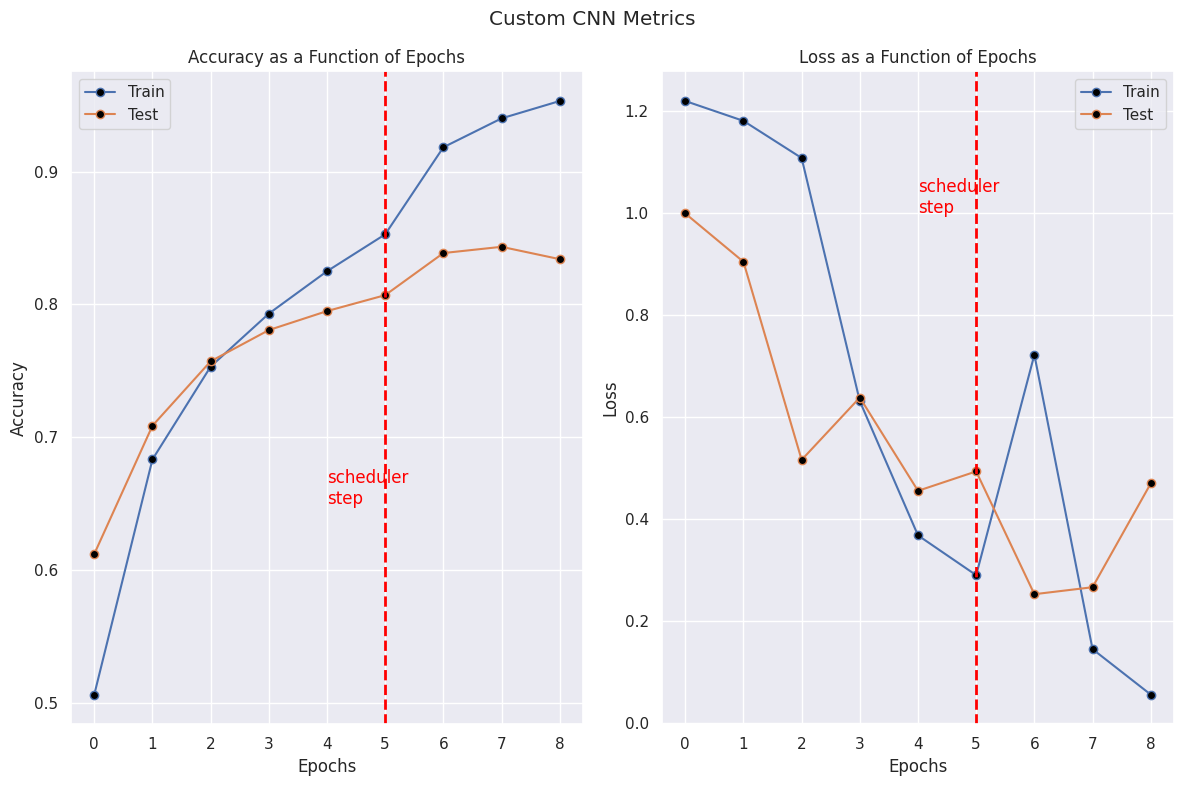

In [8]:
import seaborn as sns
sns.set()

fig, axes = plt.subplots(1, 2)

axes[0].plot(net.train_accuracies, label="Train", marker='o', markerfacecolor='black')
axes[0].plot(net.test_accuracies, label="Test", marker='o', markerfacecolor='black')
axes[0].axvline(x=5, color='red', linestyle='--', linewidth=2)
axes[0].legend()
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy as a Function of Epochs")
axes[0].text(4, 0.65, "scheduler\nstep", color='red')

axes[1].plot(net.train_losses, label="Train", marker='o', markerfacecolor='black')
axes[1].plot(net.test_losses, label="Test", marker='o', markerfacecolor='black')
axes[1].axvline(x=5, color='red', linestyle='--', linewidth=2)
axes[1].legend()
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss as a Function of Epochs")
axes[1].text(4, 1, "scheduler\nstep", color='red')


fig.suptitle('Custom CNN Metrics')
plt.tight_layout()
plt.show()
sns.reset_defaults()

[[157  12  22  19  13   8   2   4  25   7]
 [ 10 157   0   3   2   5   1   0  12  20]
 [ 46   2 155  46  45  62  17  14   5   1]
 [ 11   2  35 152  40 117  28  14   7   6]
 [  8   1  27  31 155  30  15   8   2   3]
 [  5   2  22  63  31 157   3  14   1   0]
 [  5   3  29  41  37  22 156   5   4   4]
 [ 10   0   9  22  50  52   0 157   1   7]
 [ 37   6   6  10   5   0   3   2 156  14]
 [ 31  56   2   7   4   6   2   5  10 156]]


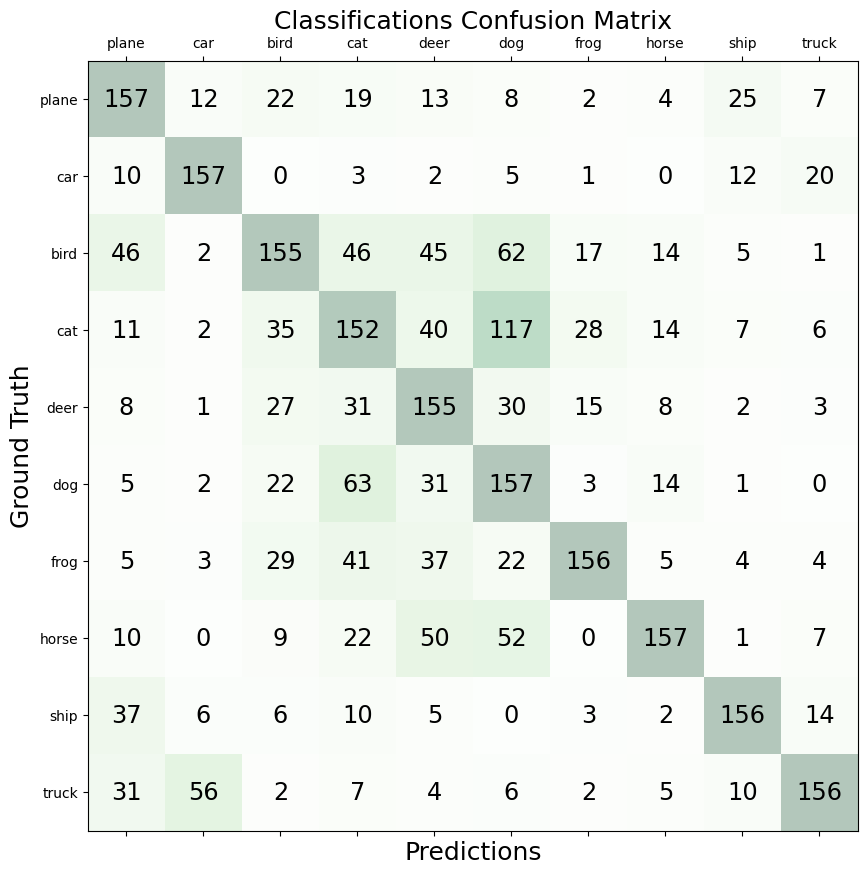

Model accuracy on 10000 test images: 0.83%


In [9]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        #
#############################################################################

corrects = 0
net.to('cpu')
with torch.no_grad():
  for X_batch, y_batch in testloader:
    y_scores = net(X_batch)
    y_pred = torch.argmax(y_scores, axis=1)
    confusion_matrix[y_batch, y_pred] +=1
    corrects += torch.sum(y_pred == y_batch).item()

print(confusion_matrix)

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confusion_matrix, cmap="Greens", alpha=0.3)

ax.set_yticks(range(len(classes)))
ax.set_xticks(range(len(classes)))

ax.set_yticklabels(classes)
ax.set_xticklabels(classes)

for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Ground Truth', fontsize=18)
plt.title('Classifications Confusion Matrix', fontsize=18)
plt.show()

model_accuracy = corrects / len(testset)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))


##**Question:**
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

#**Answer**
During this exercise i experimented with different architectures and hyper-parameters:
- **Conv layers amount**: I tryed training networks with various amount of conv layers (1, 2, ..., 7). I found out that more conv layers significantly improved performance up to a certain amount (4-5). Using only 1 conv layer resulted in bad classifications. As learned in class, the first layer mostly finds edges and simple features which is not enough for good classification.

- **Batch norm**: Adding batch norm significantly improved the performance from 79% to 84%.

- **Dropout**: I tryed adding dropout layers with different dropout rate (0.3, 0.5, 0.8) which didnt improve performance. Not used in the final architecture submitted.

- **Learning rate scheduler**: I noticed that after 4-6 epochs the network stops improving. Adding a lr scheduler improved the performance of the network, and this is noticeable in the loss visualization above.

- **Fully connected**: I tryed using 1, 2 and 3 fully connected layers with different amount of neurons. I found that 2 layers performed better than 1, but 3 didnt perform better than 2.

- **Learning rate**: As learned in class, this is one of the most significant hyper-parameters when it comes to training neural networks. I tryed 10 different learning rates in [$10^{-8}$, $10^{-1}$], and then another 10 in [$10^{-4}$, $10^{-2}$] to pick the best one.

- **Transforms**: As learned in class, data augmentation can improve the training process. I added flipping around the x axis, colorization, random crops and different normalization, which surprisingly didn't have a significant effect. Therefore, it was not used in the final implementation

In [ ]:
print(net)

Net(
  (relu): ReLU()
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

##**Question:**
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

#**Answer**

By looking at the confusion matrix, it is noticeable that the trained classifier can differentiate between certain classes better and worse.

For example, 'Automobiles' (0) are almost never classified as 'Deers' (4).
On the other hand, it is noticeable that 'Dogs' (3), Deers (4) and Cats (5) are very often confused with each other

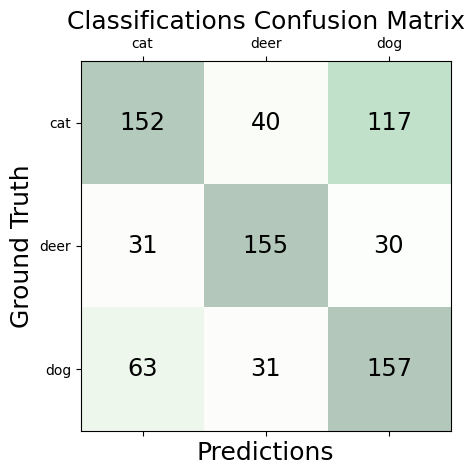

In [10]:
fig, ax = plt.subplots()
ax.matshow(confusion_matrix[3:6, 3:6], cmap="Greens", alpha=0.3)

ax.set_yticks([0, 1, 2])
ax.set_xticks([0, 1, 2])

ax.set_yticklabels(classes[3:6])
ax.set_xticklabels(classes[3:6])

for i in range(3):
    for j in range(3):
        ax.text(x=j, y=i,s=confusion_matrix[3:6, 3:6][i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Ground Truth', fontsize=18)
plt.title('Classifications Confusion Matrix', fontsize=18)
plt.show()

# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs.

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images.

In [ ]:
!unzip data.zip

Archive:  data.zip
 extracting: data/__init__.py        
   creating: data/animals/
   creating: data/animals/annotations/
  inflating: data/animals/annotations/Abyssinian_1.xml  
  inflating: data/animals/annotations/Abyssinian_10.xml  
  inflating: data/animals/annotations/Abyssinian_100.xml  
  inflating: data/animals/annotations/Abyssinian_101.xml  
  inflating: data/animals/annotations/Abyssinian_102.xml  
  inflating: data/animals/annotations/Abyssinian_103.xml  
  inflating: data/animals/annotations/Abyssinian_105.xml  
  inflating: data/animals/annotations/Abyssinian_106.xml  
  inflating: data/animals/annotations/Abyssinian_107.xml  
  inflating: data/animals/annotations/Abyssinian_108.xml  
  inflating: data/animals/annotations/Abyssinian_109.xml  
  inflating: data/animals/annotations/Abyssinian_11.xml  
  inflating: data/animals/annotations/Abyssinian_110.xml  
  inflating: data/animals/annotations/Abyssinian_111.xml  
  inflating: data/animals/annotations/Abyssinian_112.xm

In [ ]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [ ]:
#resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

<Figure size 640x480 with 0 Axes>

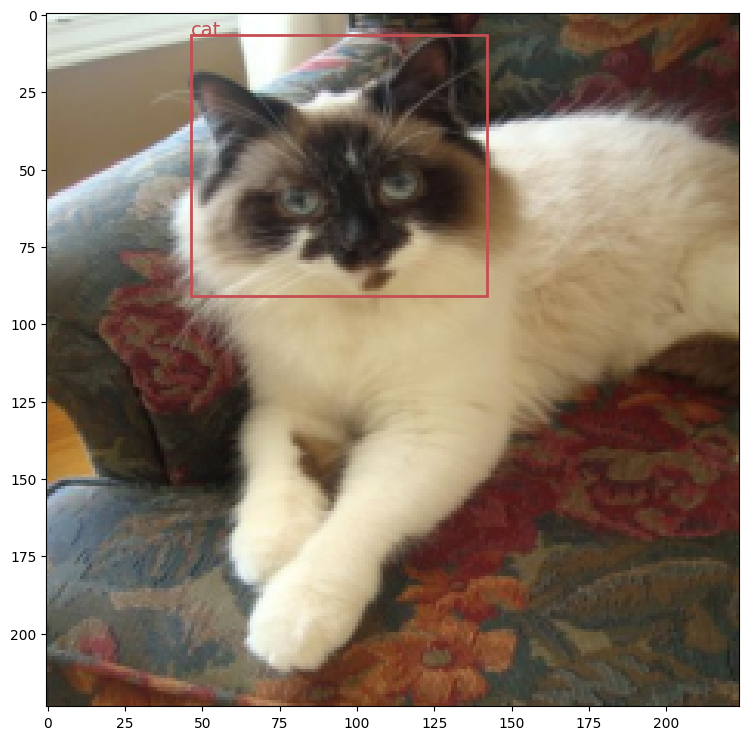

In [ ]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])
plt.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only       #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # Clarrification - You required to build 2 models - one for classification  #
        # and one for detection.                                                    #
        # The classification model is of shape: resent_features -> FC/FCs -> scores.#
        # The detection model is of shape: resent_features -> FC/FCs -> bbox.       #
        # You may train/leave frozen the resent_features backbone, try              #
        # experimenting with it.                                                    #
        # This function has no return value.                                        #
        #############################################################################

        resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        for param in resnet.parameters():
          param.requires_grad = False
        num_features = resnet.fc.in_features

        self.features_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Linear(num_features, num_classes)
        self.bbox_regressor = nn.Sequential(nn.Flatten(),
                                            nn.Linear(num_features, num_features//2),
                                            nn.ReLU(),
                                            nn.Linear(num_features//2, 4))


        self.train_losses = []
        self.train_accuracies = []
        self.train_ious = []

        self.validation_losses = []
        self.validation_accuracies = []
        self.validation_ious = []
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################

        features = self.features_extractor(images)
        features = torch.squeeze(features)

        classifications = self.classifier(features)
        bboxes = self.bbox_regressor(features)

        return classifications, bboxes
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set.
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

#**Answer**
**Architecture**

Remove classification layer, use resnet previous layers for features extraction.

**Classifier** Feature Extractor -> Linear.

I found out that it was more than enough to achieve 99% validation accuracy and a quicker training process

**BBox Regressor**

Feature Extractor -> Linear -> Relu -> Linear
I found out that two layers linear layers with activation between them gave better IOU results.

**Learning Rate Scheduler**

Improved a little bit the IOU results.
- $γ$ = 0.1
- $step-size$ = 15

**Learning Rate**:

After hyperparameters optimization, $lr=10^-3$ was chosen

**Optimizer**

I tryed SGD and Adam with different momentums.

Adam performed best with the default momentum

**Loss Function**

**Classifier**: Cross Entropy

**BBox Regressor**:

I tryed both $\ell_1$, $\ell_{1-smooth}$ and $\ell2$ and got similar results.

L1 was a little performed best and was chosen as a loss function.

**Epochs**

After ~30 epochs the model started converging. I chose 35 epochs.

**Note:**

I didn't know we had a calc_iou method given, so i developed my own.

It was developed using vectorized code to speed the training process as well.

In [ ]:
def calc_iou(bboxes_pred, bboxes):
  batch_size = bboxes.shape[0]

  # Top Left
  xs_max = torch.maximum(bboxes_pred[:,0], bboxes[:,0])
  ys_max = torch.maximum(bboxes_pred[:,1], bboxes[:,1])

  # Bottom Right
  xs_min = torch.minimum(bboxes_pred[:, 2], bboxes[:,2])
  ys_min = torch.minimum(bboxes_pred[:, 3], bboxes[:,3])

  zeros = torch.zeros(batch_size)
  if torch.cuda.is_available():
    zeros = zeros.to(device)

  intersection_height = torch.maximum(ys_min - ys_max + 1, zeros)
  intersection_width = torch.maximum(xs_min - xs_max + 1, zeros)

  area_of_intersection = intersection_height * intersection_width

  bboxes_heights = bboxes[:, 3] - bboxes[:, 1] + 1
  bboxes_widths = bboxes[:, 2] - bboxes[:, 0] + 1


  bboxes_pred_heights = bboxes_pred[:, 3] - bboxes_pred[:, 1] + 1
  bboxes_pred_widths = bboxes_pred[:, 2] - bboxes_pred[:, 0] + 1

  area_of_union = bboxes_heights * bboxes_widths + bboxes_pred_heights * bboxes_pred_widths - area_of_intersection

  ious = area_of_intersection / area_of_union
  iou = torch.sum(ious)

  return iou

In [ ]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5, reg_bbox=1):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score

            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################

                images, labels, bboxes = sample['image'], sample['label'], sample['bbox']
                if torch.cuda.is_available():
                    images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)

                optimizer.zero_grad()
                y_scores, bboxes_pred = model(images) # 32x2, 32x4
                y_pred = torch.argmax(y_scores, axis=1)

                running_corrects += torch.sum(y_pred == labels)

                classification_loss = criterion_cls(y_scores, labels)
                bbox_loss = criterion_bbox(bboxes_pred, bboxes)

                iou += calc_iou(bboxes_pred, bboxes)

                loss =  classification_loss + reg_bbox * bbox_loss
                running_loss += loss

                loss.backward()
                optimizer.step()

                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]

            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            if phase == 'train':
              model.train_losses.append(epoch_loss)
              model.train_accuracies.append(epoch_acc)
              model.train_ious.append(iou)
            else:
              model.validation_losses.append(epoch_loss)
              model.validation_accuracies.append(epoch_acc)
              model.validation_ious.append(iou)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if epoch % 10 ==0:
          print("step")
        scheduler.step()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [ ]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################

criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.L1Loss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.4MB/s]


In [ ]:
step_size = 15
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
cnn = cnn.to(device)

best_model = train_model(cnn, criterion_cls, criterion_bbox, optimizer, scheduler=scheduler, num_epochs=35)

Epoch 1/35
----------
train Loss: 0.0208  |  Acc: 0.7972  |  IOU: 0.6003
val Loss: 0.0116  |  Acc: 0.9557  |  IOU: 0.7023
step
Epoch 2/35
----------
train Loss: 0.0087  |  Acc: 0.9717  |  IOU: 0.7308
val Loss: 0.0070  |  Acc: 0.9747  |  IOU: 0.7588
Epoch 3/35
----------
train Loss: 0.0070  |  Acc: 0.9780  |  IOU: 0.7485
val Loss: 0.0055  |  Acc: 0.9873  |  IOU: 0.7732
Epoch 4/35
----------
train Loss: 0.0059  |  Acc: 0.9858  |  IOU: 0.7658
val Loss: 0.0051  |  Acc: 0.9873  |  IOU: 0.7642
Epoch 5/35
----------
train Loss: 0.0058  |  Acc: 0.9827  |  IOU: 0.7674
val Loss: 0.0045  |  Acc: 0.9937  |  IOU: 0.7811
Epoch 6/35
----------
train Loss: 0.0052  |  Acc: 0.9827  |  IOU: 0.7594
val Loss: 0.0042  |  Acc: 0.9937  |  IOU: 0.7922
Epoch 7/35
----------
train Loss: 0.0051  |  Acc: 0.9811  |  IOU: 0.7770
val Loss: 0.0037  |  Acc: 0.9937  |  IOU: 0.8115
Epoch 8/35
----------
train Loss: 0.0044  |  Acc: 0.9890  |  IOU: 0.7914
val Loss: 0.0033  |  Acc: 0.9937  |  IOU: 0.8183
Epoch 9/35
--------

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

In [ ]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

In [ ]:
def ims_show(images, pred_labels, pred_bboxes, gt_labels, gt_bboxes,axes):
    for i in range(len(images)):
      image = np.copy(images[i])
      image = np.transpose(image, (1, 2, 0))
      image *= np.array([0.229, 0.224, 0.225])
      image += np.array([0.485, 0.456, 0.406])
      pred_label = pred_labels[i]
      pred_bbox = pred_bboxes[i]

      gt_label = pred_labels[i]
      gt_bbox = gt_bboxes[i]

      row = i // 4
      column = i % 4

      # Normalize img to avoid pyplot warnings
      img_normalized = (image - image.min()) / (image.max() - image.min())

      axes[row, column].imshow(img_normalized);
      # Draw pred bbox
      x1, y1, x2, y2 = pred_bbox.numpy().reshape(-1) * 224
      box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
      pred_bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                              edgecolor='r', facecolor='none');
      axes[row, column].add_patch(pred_bbox);
      axes[row, column].annotate(classes[pred_label], (x1, y1), color='r', fontsize=14);

      #Draw gt bbox
      x1, y1, x2, y2 = gt_bbox.numpy().reshape(-1) * 224
      box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
      gt_bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                              edgecolor='g', facecolor='none');
      axes[row, column].add_patch(gt_bbox);
      axes[row, column].annotate(classes[gt_label], (x1, y1), color='g', fontsize=14);
    plt.show()

#**Classification & Object Detection Visualization**
- **Green:** Ground truth boxes and labels
- **Red:** Predicted boxes and labels

It seems that the classifier predicts labels correctly 100%.
Moreover, the predicted boxes seem very similar to the ground truth as well.

<Figure size 640x480 with 0 Axes>

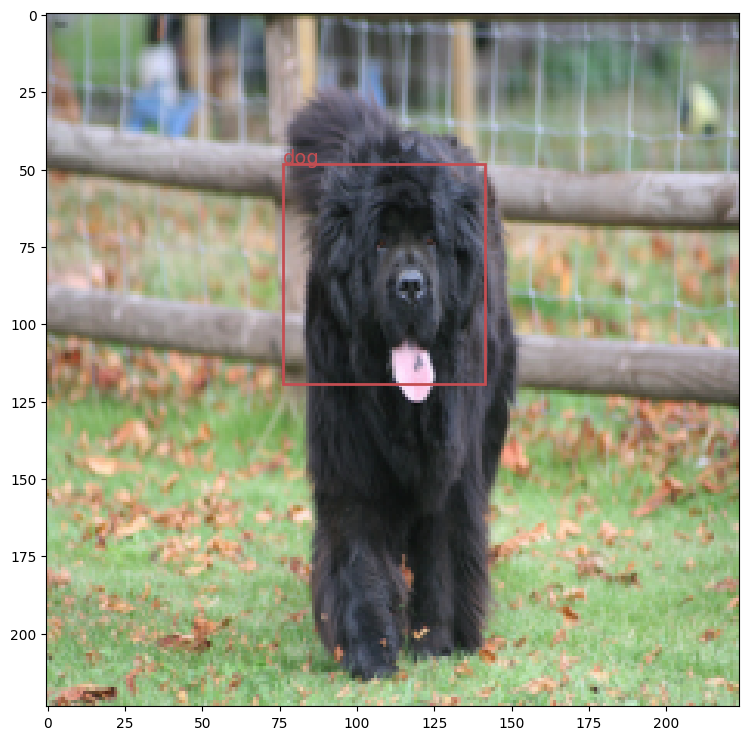

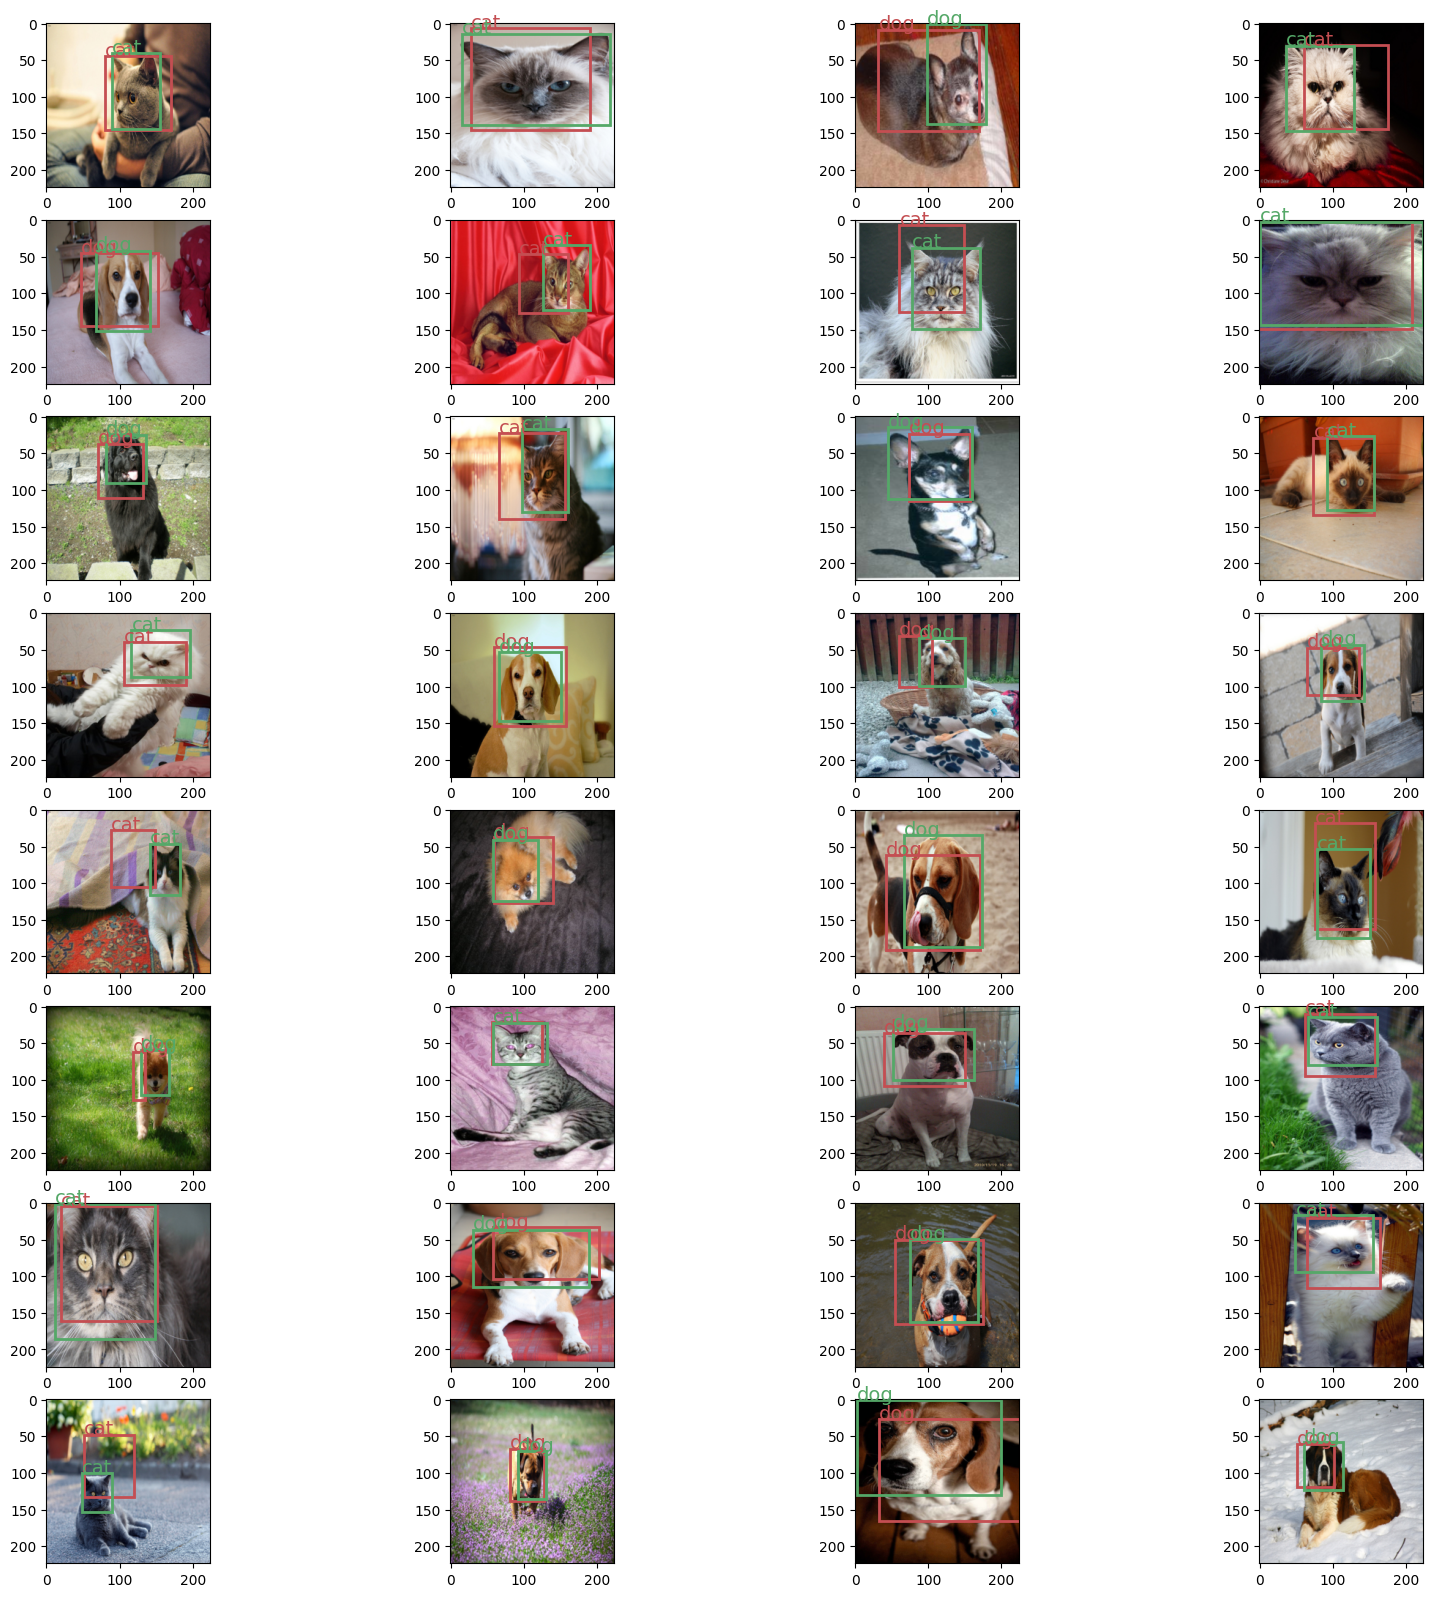

In [ ]:
fig, axes = plt.subplots(8, 4, figsize = (20, 20))

sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
    gt_labels = sample['label']
    gt_bboxes = sample['bbox']
ims_show(sample['image'], label_pred.cpu(), bbox_pred.cpu(), gt_labels, gt_bboxes, axes)


#**Classification and Detection Metrics Visualization**
The Custom CNN was trained for 40 epochs.

Scheduler steps are marked by red vertical lines

**Validation Loss:** 0.0016

**Validation Acc:** 100%

**Validation IOU:** 88.5%

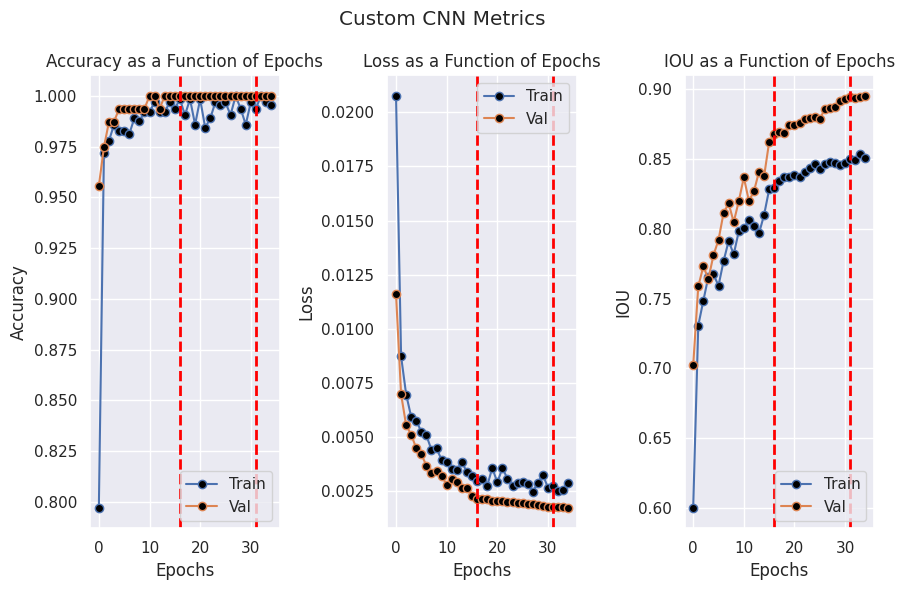

In [ ]:
import seaborn as sns
sns.set()

fig, axes = plt.subplots(1, 3, figsize=(9, 6))

if torch.cuda.is_available():
  best_model.train_accuracies = [train_accuracy.cpu() for train_accuracy in best_model.train_accuracies]
  best_model.train_losses = [train_loss.cpu().detach() for train_loss in best_model.train_losses]
  #best_model.train_ious = [train_iou.cpu() for train_iou in best_model.train_ious]

  best_model.validation_accuracies = [validation_accuracy.cpu() for validation_accuracy in best_model.validation_accuracies]
  best_model.validation_losses = [validation_loss.cpu().detach() for validation_loss in best_model.validation_losses]
  #best_model.validation_ious = [validation_iou.cpu() for validation_iou in best_model.validation_ious]

axes[0].plot(best_model.train_accuracies, label="Train", marker='o', markerfacecolor='black')
axes[0].plot(best_model.validation_accuracies, label="Val", marker='o', markerfacecolor='black')
for i in range(16, 40, 15):
  axes[0].axvline(x=i, color='red', linestyle='--', linewidth=2)
axes[0].legend()
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy as a Function of Epochs")

axes[1].plot(best_model.train_losses, label="Train", marker='o', markerfacecolor='black')
axes[1].plot(best_model.validation_losses, label="Val", marker='o', markerfacecolor='black')
for i in range(16, 40, 15):
  axes[1].axvline(x=i, color='red', linestyle='--', linewidth=2)
axes[1].legend()
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss as a Function of Epochs")

axes[2].plot(best_model.train_ious, label="Train", marker='o', markerfacecolor='black')
axes[2].plot(best_model.validation_ious, label="Val", marker='o', markerfacecolor='black')
for i in range(16, 40, 15):
  axes[2].axvline(x=i, color='red', linestyle='--', linewidth=2)
axes[2].legend()
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("IOU")
axes[2].set_title("IOU as a Function of Epochs")

fig.suptitle('Custom CNN Metrics')
plt.tight_layout()
plt.show()
sns.reset_defaults()